### Required Imports

In [297]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt_tab')
from collections import Counter
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load, Preprocess and tokenize data

1. Load, preprocess, and tokenize the data. Preprocessing steps should include lemmatizing,removing punctuation, special characters, digits, and extra spaces. Feel free to use a package like nltk or spacy.

In [269]:
# Load the Rotten Tomatoes polarity dataset
def load_rt_dataset():
    reviews = []
    for sentiment in ['pos', 'neg']:
        path = f'rt-polarity.{sentiment}'
        file = open(path)
        for line in file.readlines():
            review = line.strip()
            reviews.append({'review': review, 'sentiment': sentiment})
    return pd.DataFrame(reviews)

In [270]:
reviews = load_rt_dataset()
print(reviews.head())

                                              review sentiment
0  the rock is destined to be the 21st century's ...       pos
1  the gorgeously elaborate continuation of " the...       pos
2                     effective but too-tepid biopic       pos
3  if you sometimes like to go to the movies to h...       pos
4  emerges as something rare , an issue movie tha...       pos


In [271]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(text : str) -> list:

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return (tokens)

In [272]:
pdf = []
for i in reviews['review']:
   pdf.append(preprocess(i))

reviews['preprocessed_review'] = pdf
print(reviews['preprocessed_review'])

0        [the, rock, is, destined, to, be, the, st, cen...
1        [the, gorgeously, elaborate, continuation, of,...
2                       [effective, but, tootepid, biopic]
3        [if, you, sometimes, like, to, go, to, the, mo...
4        [emerges, a, something, rare, an, issue, movie...
                               ...                        
10657    [a, terrible, movie, that, some, people, will,...
10658    [there, are, many, definition, of, time, waste...
10659    [a, it, stand, crocodile, hunter, ha, the, hur...
10660    [the, thing, look, like, a, madeforhomevideo, ...
10661    [enigma, is, wellmade, but, it, just, too, dry...
Name: preprocessed_review, Length: 10662, dtype: object


In [273]:
preprocessed_documents = reviews['review'].apply(preprocess)
print(f'Number of preprocessed documents: {len(preprocessed_documents)}')
print(preprocessed_documents.head())

Number of preprocessed documents: 10662
0    [the, rock, is, destined, to, be, the, st, cen...
1    [the, gorgeously, elaborate, continuation, of,...
2                   [effective, but, tootepid, biopic]
3    [if, you, sometimes, like, to, go, to, the, mo...
4    [emerges, a, something, rare, an, issue, movie...
Name: review, dtype: object


### Build vocabulary

making the token2index and index2token dictionaries ready for use later

3. Convert the string tokens into indices with dictionaries keeping track of the vocabulary

In [274]:
def build_vocab(tokenized_texts):
    counter = Counter([token for text in tokenized_texts for token in text])
    token2index = {token: idx + 1 for idx, (token, _) in enumerate(counter.items())}
    token2index['[PAD]'] = 0  # Reserve 0 for padding
    index2token = {idx: token for token, idx in token2index.items()}
    return token2index, index2token

In [275]:
# Make a token2index dictionary and a index2token dictionary and convert the documents to sequences of indices
token2index = {}
index2token = {}

token2index, index2token = build_vocab(preprocessed_documents)

print(f'Number of unique tokens: {len(token2index)}')

Number of unique tokens: 18317


In [276]:
print(token2index)

{'the': 1, 'rock': 2, 'is': 3, 'destined': 4, 'to': 5, 'be': 6, 'st': 7, 'century': 8, 'new': 9, 'conan': 10, 'and': 11, 'that': 12, 'he': 13, 'going': 14, 'make': 15, 'a': 16, 'splash': 17, 'even': 18, 'greater': 19, 'than': 20, 'arnold': 21, 'schwarzenegger': 22, 'jeanclaud': 23, 'van': 24, 'damme': 25, 'or': 26, 'steven': 27, 'segal': 28, 'gorgeously': 29, 'elaborate': 30, 'continuation': 31, 'of': 32, 'lord': 33, 'ring': 34, 'trilogy': 35, 'so': 36, 'huge': 37, 'column': 38, 'word': 39, 'can': 40, 'not': 41, 'adequately': 42, 'describe': 43, 'cowriterdirector': 44, 'peter': 45, 'jackson': 46, 'expanded': 47, 'vision': 48, 'j': 49, 'r': 50, 'tolkien': 51, 'middleearth': 52, 'effective': 53, 'but': 54, 'tootepid': 55, 'biopic': 56, 'if': 57, 'you': 58, 'sometimes': 59, 'like': 60, 'go': 61, 'movie': 62, 'have': 63, 'fun': 64, 'wasabi': 65, 'good': 66, 'place': 67, 'start': 68, 'emerges': 69, 'something': 70, 'rare': 71, 'an': 72, 'issue': 73, 'thats': 74, 'honest': 75, 'keenly': 76, 

In [277]:
print(index2token)

{1: 'the', 2: 'rock', 3: 'is', 4: 'destined', 5: 'to', 6: 'be', 7: 'st', 8: 'century', 9: 'new', 10: 'conan', 11: 'and', 12: 'that', 13: 'he', 14: 'going', 15: 'make', 16: 'a', 17: 'splash', 18: 'even', 19: 'greater', 20: 'than', 21: 'arnold', 22: 'schwarzenegger', 23: 'jeanclaud', 24: 'van', 25: 'damme', 26: 'or', 27: 'steven', 28: 'segal', 29: 'gorgeously', 30: 'elaborate', 31: 'continuation', 32: 'of', 33: 'lord', 34: 'ring', 35: 'trilogy', 36: 'so', 37: 'huge', 38: 'column', 39: 'word', 40: 'can', 41: 'not', 42: 'adequately', 43: 'describe', 44: 'cowriterdirector', 45: 'peter', 46: 'jackson', 47: 'expanded', 48: 'vision', 49: 'j', 50: 'r', 51: 'tolkien', 52: 'middleearth', 53: 'effective', 54: 'but', 55: 'tootepid', 56: 'biopic', 57: 'if', 58: 'you', 59: 'sometimes', 60: 'like', 61: 'go', 62: 'movie', 63: 'have', 64: 'fun', 65: 'wasabi', 66: 'good', 67: 'place', 68: 'start', 69: 'emerges', 70: 'something', 71: 'rare', 72: 'an', 73: 'issue', 74: 'thats', 75: 'honest', 76: 'keenly', 

### Truncate sequences

2. Write a function that truncates sequences to a certain length. For the sequences that are less than that length, add a special [PAD] token to pad it to the same length as all other sequences. Let’s start with a length of 40, and then you can decrease if you have trouble running the model on sequences that large.

In [278]:
# Truncate the sequences
def pad_sequence(sequence, max_length):
    if len(sequence) < max_length:
        sequence += [0] * (max_length - len(sequence))  # Pad with [PAD] index
    else:
        sequence = sequence[:max_length]  # Truncate to max_length
    return sequence

# Maximum sequence length
max_length = 40

In [279]:
# Convert the dataset into sequences of indices
def document_to_sequence(document : str) -> list:
    return [token2index[token] for token in document]

sequences = preprocessed_documents.apply(document_to_sequence)
print(sequences.head()) # should now be a list of indices

0    [1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13,...
1    [1, 29, 30, 31, 32, 1, 33, 32, 1, 34, 35, 3, 3...
2                                     [53, 54, 55, 56]
3    [57, 58, 59, 60, 5, 61, 5, 1, 62, 5, 63, 64, 6...
4    [69, 16, 70, 71, 72, 73, 62, 74, 36, 75, 11, 7...
Name: review, dtype: object


In [280]:
# Truncate the sequences
truncated_sequences = sequences.apply(lambda x: pad_sequence(x, max_length))

print(truncated_sequences.head())

0    [1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13,...
1    [1, 29, 30, 31, 32, 1, 33, 32, 1, 34, 35, 3, 3...
2    [53, 54, 55, 56, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3    [57, 58, 59, 60, 5, 61, 5, 1, 62, 5, 63, 64, 6...
4    [69, 16, 70, 71, 72, 73, 62, 74, 36, 75, 11, 7...
Name: review, dtype: object


### Convert data to tensors

4. Finally, convert the data into X and y tensors for ingestion into our PyTorch model.

In [282]:
# convert the sequences to tensors and create dataloaders
# for training, validation, and testing

In [283]:
# Split the dataset into training and testing sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(truncated_sequences, reviews['sentiment'], test_size=0.2, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, test_size=0.5, random_state=42)

In [284]:
# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.tolist())
y_val = label_encoder.transform(y_val.tolist())
y_test = label_encoder.transform(y_test.tolist())

In [285]:
# Convert the vectorized reviews to numpy arrays
X_train = torch.tensor(X_train.tolist())
X_val = torch.tensor(X_val.tolist())
X_test = torch.tensor(X_test.tolist())
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

In [286]:
# Define the dataset class
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

In [287]:
# Define the dataloader
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [288]:
# check the first sequence with index2token
print([index2token[i.item()] for i in train_data.tensors[0][0]])

['not', 'everything', 'work', 'but', 'the', 'average', 'is', 'higher', 'than', 'in', 'mary', 'and', 'most', 'other', 'recent', 'comedy', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


### Create the neural network

5. Create a neural network in PyTorch according to the following specifications

In [250]:
class Net(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, num_embeddings: int, embedding_dim: int,
                 padding_idx: int = 0, pretrained_embeddings: torch.Tensor = None, freeze_embeddings: bool = False):
        super(Net, self).__init__()

        # Ensure padding_idx is set to the index of the [PAD] token
        pad_idx = padding_idx if padding_idx is not None else token2index['[PAD]']

        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pad_idx, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=pad_idx)
        self.linear1 = nn.Linear(embedding_dim, hidden_size)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1) # take the mean of the embeddings
        x = self.linear1(x)  # First linear layer
        x = self.activation(x)  # ReLU activation
        x = self.linear2(x)  # Second linear layer
        x = self.sigmoid(x)  # Sigmoid activation for binary classification

        return x

In [251]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [338]:
d = 50
h = 50
batch_size = 16
num_epochs = 10
learning_rate = 0.001


In [316]:
# Initialize the model
model = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0
)

In [317]:
# Define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(3,0.01)

### Train and evaluate model

6. Train and evaluate the network on F1 and accuracy. Feel free to use a package such as sklearn for metrics

In [ ]:
# Training Loop
def train_model(model,train_loader,val_loader,criterion,optimizer,num_epochs,early_stopper):
  avg_train_losses = []
  avg_val_losses = []
  for epoch in range(num_epochs):
      losses = []
      model.train()  
      for i, batch in enumerate(train_loader):
          inputs, targets = batch

          optimizer.zero_grad()

          outputs = model(inputs) 

          outputs = outputs.view(-1)  

          loss = criterion(outputs, targets.float())
          losses.append(loss.item())

          loss.backward()
          optimizer.step()


      avg_loss = sum(losses) / len(losses)
      
      model.eval()  
      val_losses = []
      with torch.no_grad():
          for inputs, targets in val_loader:
              outputs = model(inputs)  

              outputs = outputs.view(-1)

              val_loss = criterion(outputs, targets.float())
              val_losses.append(val_loss.item())

      val_loss = sum(val_losses) / len(val_losses)
      print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
      print(f'Validation Loss: {val_loss:.4f}')
      avg_train_losses.append(avg_loss)
      avg_val_losses.append(val_loss)

      if early_stopper.early_stop(val_loss):
          print("Early Stop Triggered")
          break

  return model, avg_train_losses, avg_val_losses


In [319]:
model, avg_train_losses, avg_val_losses = train_model(model,train_loader,val_loader,criterion,optimizer,num_epochs,early_stopper)

Epoch 1, Training Loss: 0.6738
Validation Loss: 0.6503
Epoch 2, Training Loss: 0.5636
Validation Loss: 0.5876
Epoch 3, Training Loss: 0.4233
Validation Loss: 0.5757
Epoch 4, Training Loss: 0.3153
Validation Loss: 0.5993
Epoch 5, Training Loss: 0.2343
Validation Loss: 0.6497
Epoch 6, Training Loss: 0.1728
Validation Loss: 0.7195
Early Stop Triggered


In [320]:
print(avg_train_losses)
print(avg_val_losses)

[0.6738163627377164, 0.5636453827780284, 0.4233279876090056, 0.31529762153775337, 0.23426311028064387, 0.17279646322148598]
[0.6503424688951293, 0.5875613711663147, 0.5757476171450828, 0.5993066127620527, 0.6497121820254113, 0.7195375406030399]


In [321]:
def plot_loss_graph(train_losses, val_losses):
  plt.figure(figsize=(10, 6))
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')
  plt.legend()
  plt.grid(True)
  plt.show()

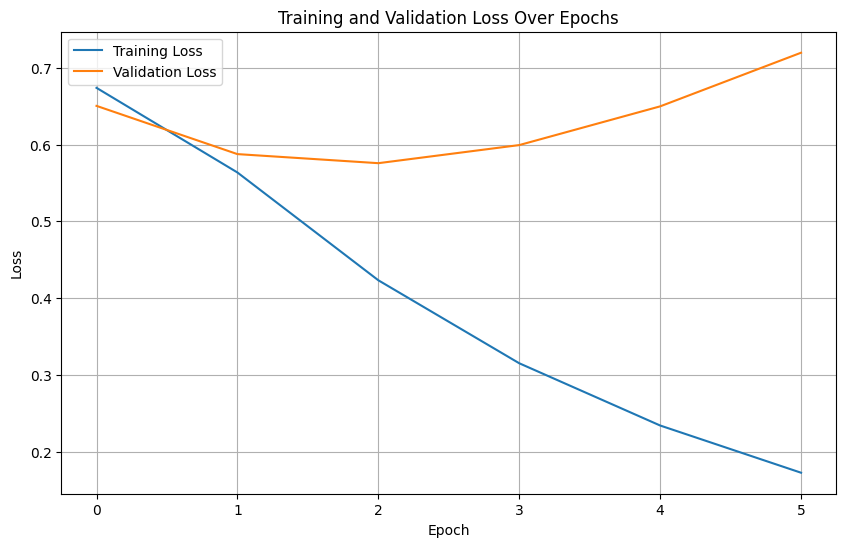

In [322]:
plot_loss_graph(avg_train_losses, avg_val_losses)

In [ ]:
# Evaluate the model
def evaluate_model(loader, model):
  test_inputs, test_targets = next(iter(loader))  
  with torch.no_grad():
      test_outputs = model(test_inputs.to('cpu'))

  predictions = (test_outputs.view(-1) >= 0.5).long().numpy()
  test_targets = test_targets.numpy()

  accuracy = accuracy_score(test_targets, predictions)
  precision = precision_score(test_targets, predictions)
  recall = recall_score(test_targets, predictions)
  f1 = f1_score(test_targets, predictions)

  print(f'Accuracy: {accuracy:.4f}')
  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1 Score: {f1:.4f}')

  return f1


In [416]:
evaluate_model(test_loader, model)

Accuracy: 0.7467
Precision: 0.7308
Recall: 0.7563
F1 Score: 0.7433


0.7433460076045627

### GloVe embeddings

7. Modify your network so that it accepts pre-trained embeddings for the embedding layer, and train another network on GloVe embeddings of the same dimensionality you used for #6.

In [339]:
################## Getting GloVe embeddings ##################

import gensim.downloader as api
embedding_dim = d
word_vectors = api.load(f"glove-wiki-gigaword-{embedding_dim}")

# Create the embedding matrix with the pretrained embeddings and the token2index dictionary
embedding_matrix = torch.zeros(len(token2index), embedding_dim)
for token, index in token2index.items():
    if token in word_vectors:
        embedding_matrix[index] = torch.tensor(word_vectors[token])

In [340]:

model_glove = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=embedding_dim,
    padding_idx=0,
    pretrained_embeddings=embedding_matrix
)

In [341]:
# Define the loss function and the optimizer
criterion_glove = nn.BCELoss()
optimizer_glove = torch.optim.Adam(model_glove.parameters(), lr=0.001)
early_stopper = EarlyStopper(3,0.01)

In [342]:
model_glove, avg_train_losses_glove, avg_val_losses_glove = train_model(model_glove,train_loader,val_loader,criterion_glove,optimizer_glove,num_epochs,early_stopper)

Epoch 1, Training Loss: 0.6428
Validation Loss: 0.5863
Epoch 2, Training Loss: 0.4821
Validation Loss: 0.5191
Epoch 3, Training Loss: 0.3479
Validation Loss: 0.5252
Epoch 4, Training Loss: 0.2479
Validation Loss: 0.5632
Epoch 5, Training Loss: 0.1737
Validation Loss: 0.6208
Epoch 6, Training Loss: 0.1211
Validation Loss: 0.6881
Early Stop Triggered


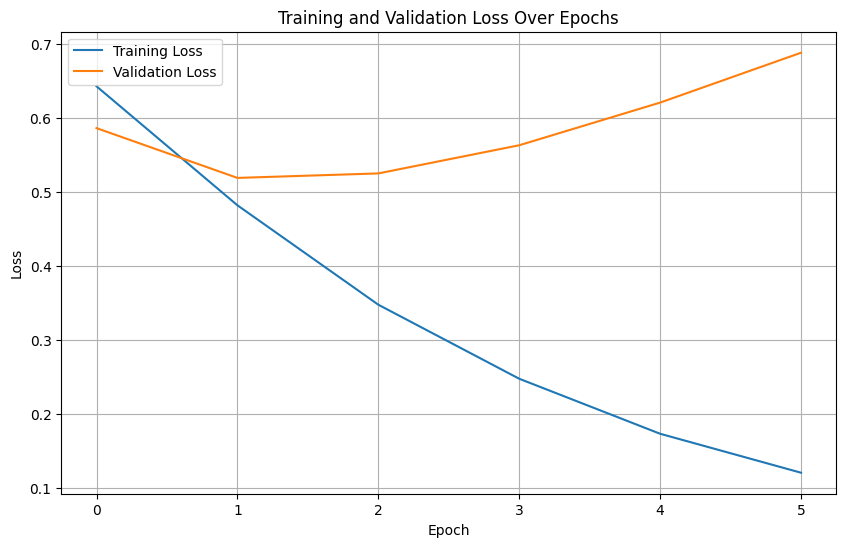

In [343]:
plot_loss_graph(avg_train_losses_glove, avg_val_losses_glove)

In [349]:
def plot_comparison_graph(avg_train_losses, avg_train_losses_glove, avg_val_losses, avg_val_losses_glove):
  plt.figure(figsize=(12, 6))

  # Plot training losses
  plt.plot(avg_train_losses, label='Model Embedding (Train)', color='red', linestyle='-')
  plt.plot(avg_train_losses_glove, label='GloVe (Train)', color='blue', linestyle='-')

  # Plot validation losses
  plt.plot(avg_val_losses, label='Model Embedding (Val)', color='red', linestyle='--')
  plt.plot(avg_val_losses_glove, label='GloVe (Val)', color='blue', linestyle='--')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss: Your Embedding vs. GloVe')
  plt.legend()
  plt.grid(True)
  plt.show()

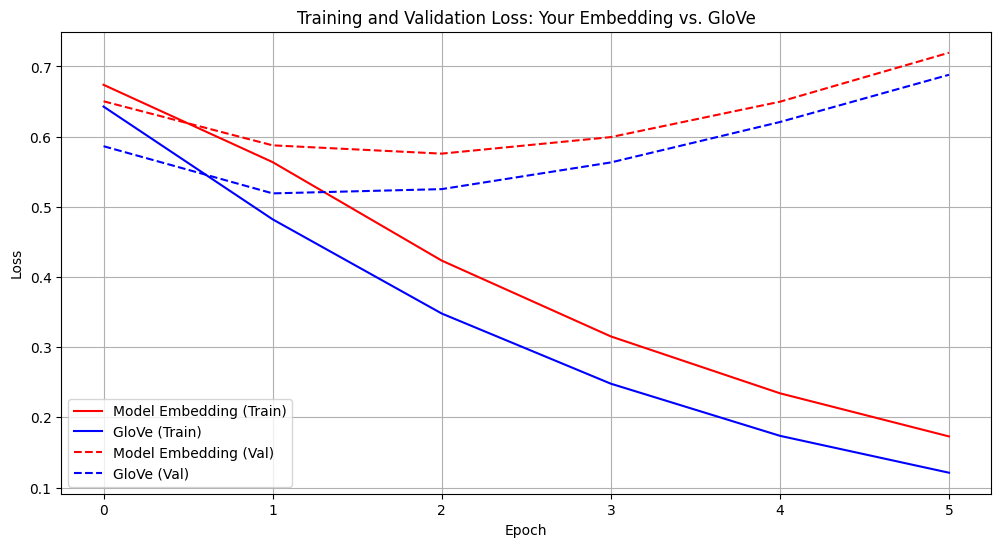

In [350]:
plot_comparison_graph(avg_train_losses, avg_train_losses_glove, avg_val_losses, avg_val_losses_glove)

In [263]:
evaluate_model(test_loader, model_glove)

Accuracy: 0.7608
Precision: 0.7549
Recall: 0.7505
F1 Score: 0.7527


In [294]:
embeddings = model.embedding.weight.data

In [296]:
print(embeddings[token2index['good']])

tensor([-0.3941, -0.0235,  0.2544,  0.4905,  1.4966, -0.0388,  0.3689,  1.2952,
        -1.4651, -0.1927,  0.6740, -0.1780,  0.0229,  0.9015, -0.3520, -1.1709,
         1.0995, -0.1574, -0.5704, -0.0893,  1.1108, -1.4859,  0.1473, -1.1117,
        -1.4909,  0.1176, -0.7008, -0.3270, -1.8656, -0.0762, -0.8701, -0.5714,
        -2.0392,  0.4785, -1.1805, -1.2920, -1.6803,  2.0961, -0.1192,  0.2409,
         2.4144, -2.1513, -0.8492,  0.3625, -0.5380, -0.7842,  0.4275,  1.1266,
        -0.6729, -0.0881])


### k-nearest neighbors

8. Implement a k-nearest-neighbors function that takes an embedding matrix, a token, a token-to-index dict, and an integer k, and returns the k nearest neighbors in the embedding space, using cosine similarity as the distance function

In [264]:
def cosine_similarity(a, b):
    """Compute cosine similarity between two vectors."""
    dot_product = torch.dot(a, b)
    norm_a = torch.norm(a)
    norm_b = torch.norm(b)
    return dot_product / (norm_a * norm_b)

In [ ]:
# Get nearest neighbors using cosine similarity

def k_nearest_neighbors(embeddings, token2index, index2token, token, k: int = 5):
   
    token_index = token2index.get(token)
    if token_index is None:
        raise ValueError(f"Token '{token}' not found in the vocabulary.")

    token_embedding = embeddings[token_index]

    pad_index = token2index['[PAD]']

    similarities = []
    for idx in range(len(embeddings)):
        if idx == pad_index or idx == token_index:
            continue  
        similarity = cosine_similarity(token_embedding, embeddings[idx])
        similarities.append((idx, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)

    top_k_indices = [idx for idx, sim in similarities[:k]]

    nearest_neighbors = [index2token[idx] for idx in top_k_indices]

    return nearest_neighbors



In [266]:
# Get the nearest neighbors of the word 'good'
k_nearest_neighbors(embedding_matrix, token2index, index2token, 'good', k=10)

['always',
 'better',
 'way',
 'something',
 'you',
 'kind',
 'everyone',
 'got',
 'make',
 'really']

In [293]:
k_nearest_neighbors(embeddings, token2index, index2token, 'good', k=10)

['wannabehip',
 'lionize',
 'reawaken',
 'kong',
 'munch',
 'filmgoers',
 'maverick',
 'malapropism',
 'purposeless',
 'ageism']

### Plots

9. Experiment with plotting your trained embeddings, versus the pre-trained GloVe embeddings. We’ve provided the plotting code for you in a3-explore-scaffolding.py; just ensure that you are able to run it with your embeddings so that you can use the plots in your report

In [267]:
def plot_embeddings_3d(embeddings, num_embeddings_to_plot: int = 250):

    # Don't plot stopwords
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    non_stop_words = [token for token in list(token2index.keys()) if token not in stop_words]
    indices_to_take = [token2index[token] for token in non_stop_words[:num_embeddings_to_plot]]
    subset_of_embeddings = embeddings[indices_to_take, :]

    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    # PCA
    pca = PCA(n_components=3)
    components = pca.fit_transform(subset_of_embeddings)

    # Create a 3D scatter plot of the projection
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(components[:, 0], components[:, 1], components[:, 2], s=10)

    for i, index_in_dict in enumerate(indices_to_take):
        token = index2token[index_in_dict]
        ax.text(components[i, 0], components[i, 1], components[i, 2], token)
    plt.show()


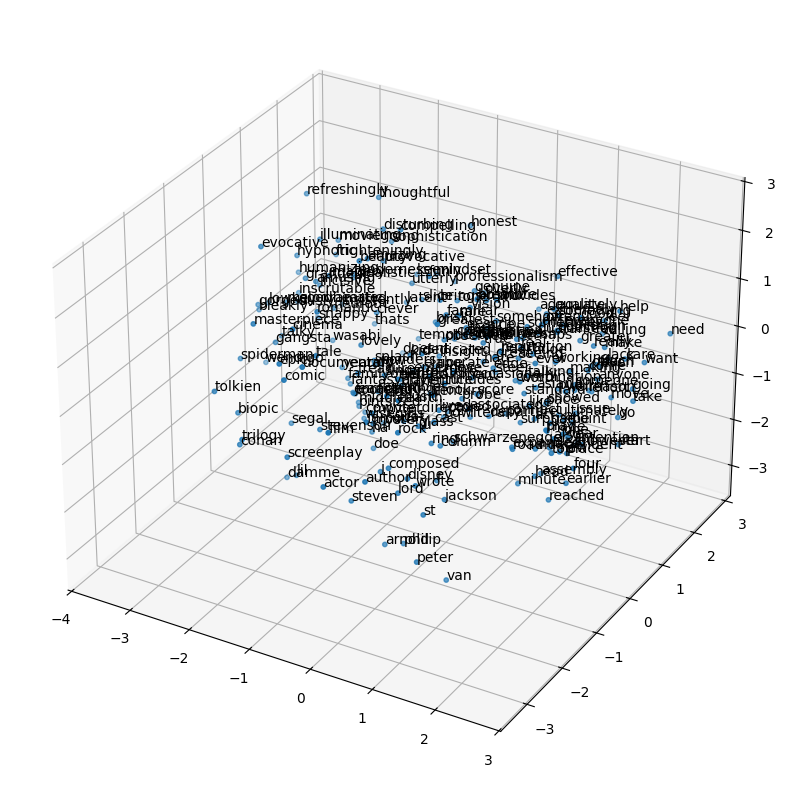

In [230]:
plot_embeddings_3d(embedding_matrix, 250)

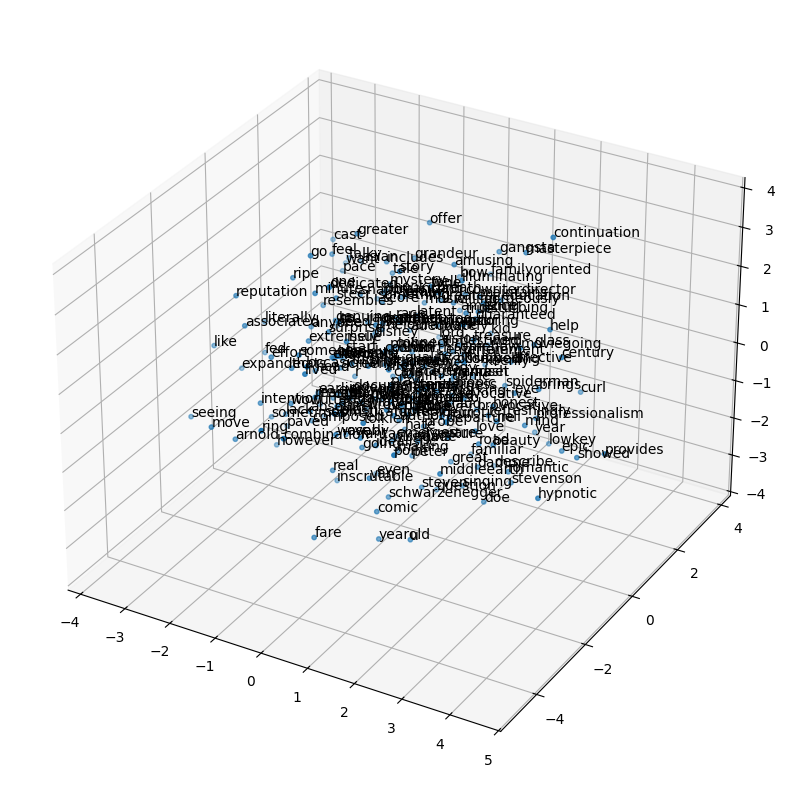

In [291]:
plot_embeddings_3d(embeddings, 250)

In [193]:
def plot_embeddings_tsne(embeddings, num_embeddings_to_plot: int = 2000, pca_n_components: int = 50):
    # Don't plot stopwords
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    non_stop_words = [token for token in list(token2index.keys()) if token not in stop_words]
    indices_to_take = [token2index[token] for token in non_stop_words[:num_embeddings_to_plot]]
    subset_of_embeddings = embeddings[indices_to_take, :]

    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    random_state = 42
    vocab = [index2token[index] for index in indices_to_take]
    colors = ['black' for i in vocab]
    # reduction with PCA
    pca = PCA(n_components=pca_n_components, random_state=random_state)
    X = pca.fit_transform(subset_of_embeddings)
    # t-SNE:
    tsne = TSNE(
        n_components=2,
        init='random',
        learning_rate='auto',
        random_state=random_state)
    tsnemat = tsne.fit_transform(X)
    # Plot values:
    xvals = tsnemat[: , 0]
    yvals = tsnemat[: , 1]
    # Plotting:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,30))
    ax.plot(xvals, yvals, marker='', linestyle='')
    # Text labels:
    for word, x, y, color in zip(vocab, xvals, yvals, colors):
        try:
            ax.annotate(word, (x, y), fontsize=8, color=color)
        except UnicodeDecodeError:
            pass
    plt.axis('off')
    plt.show()

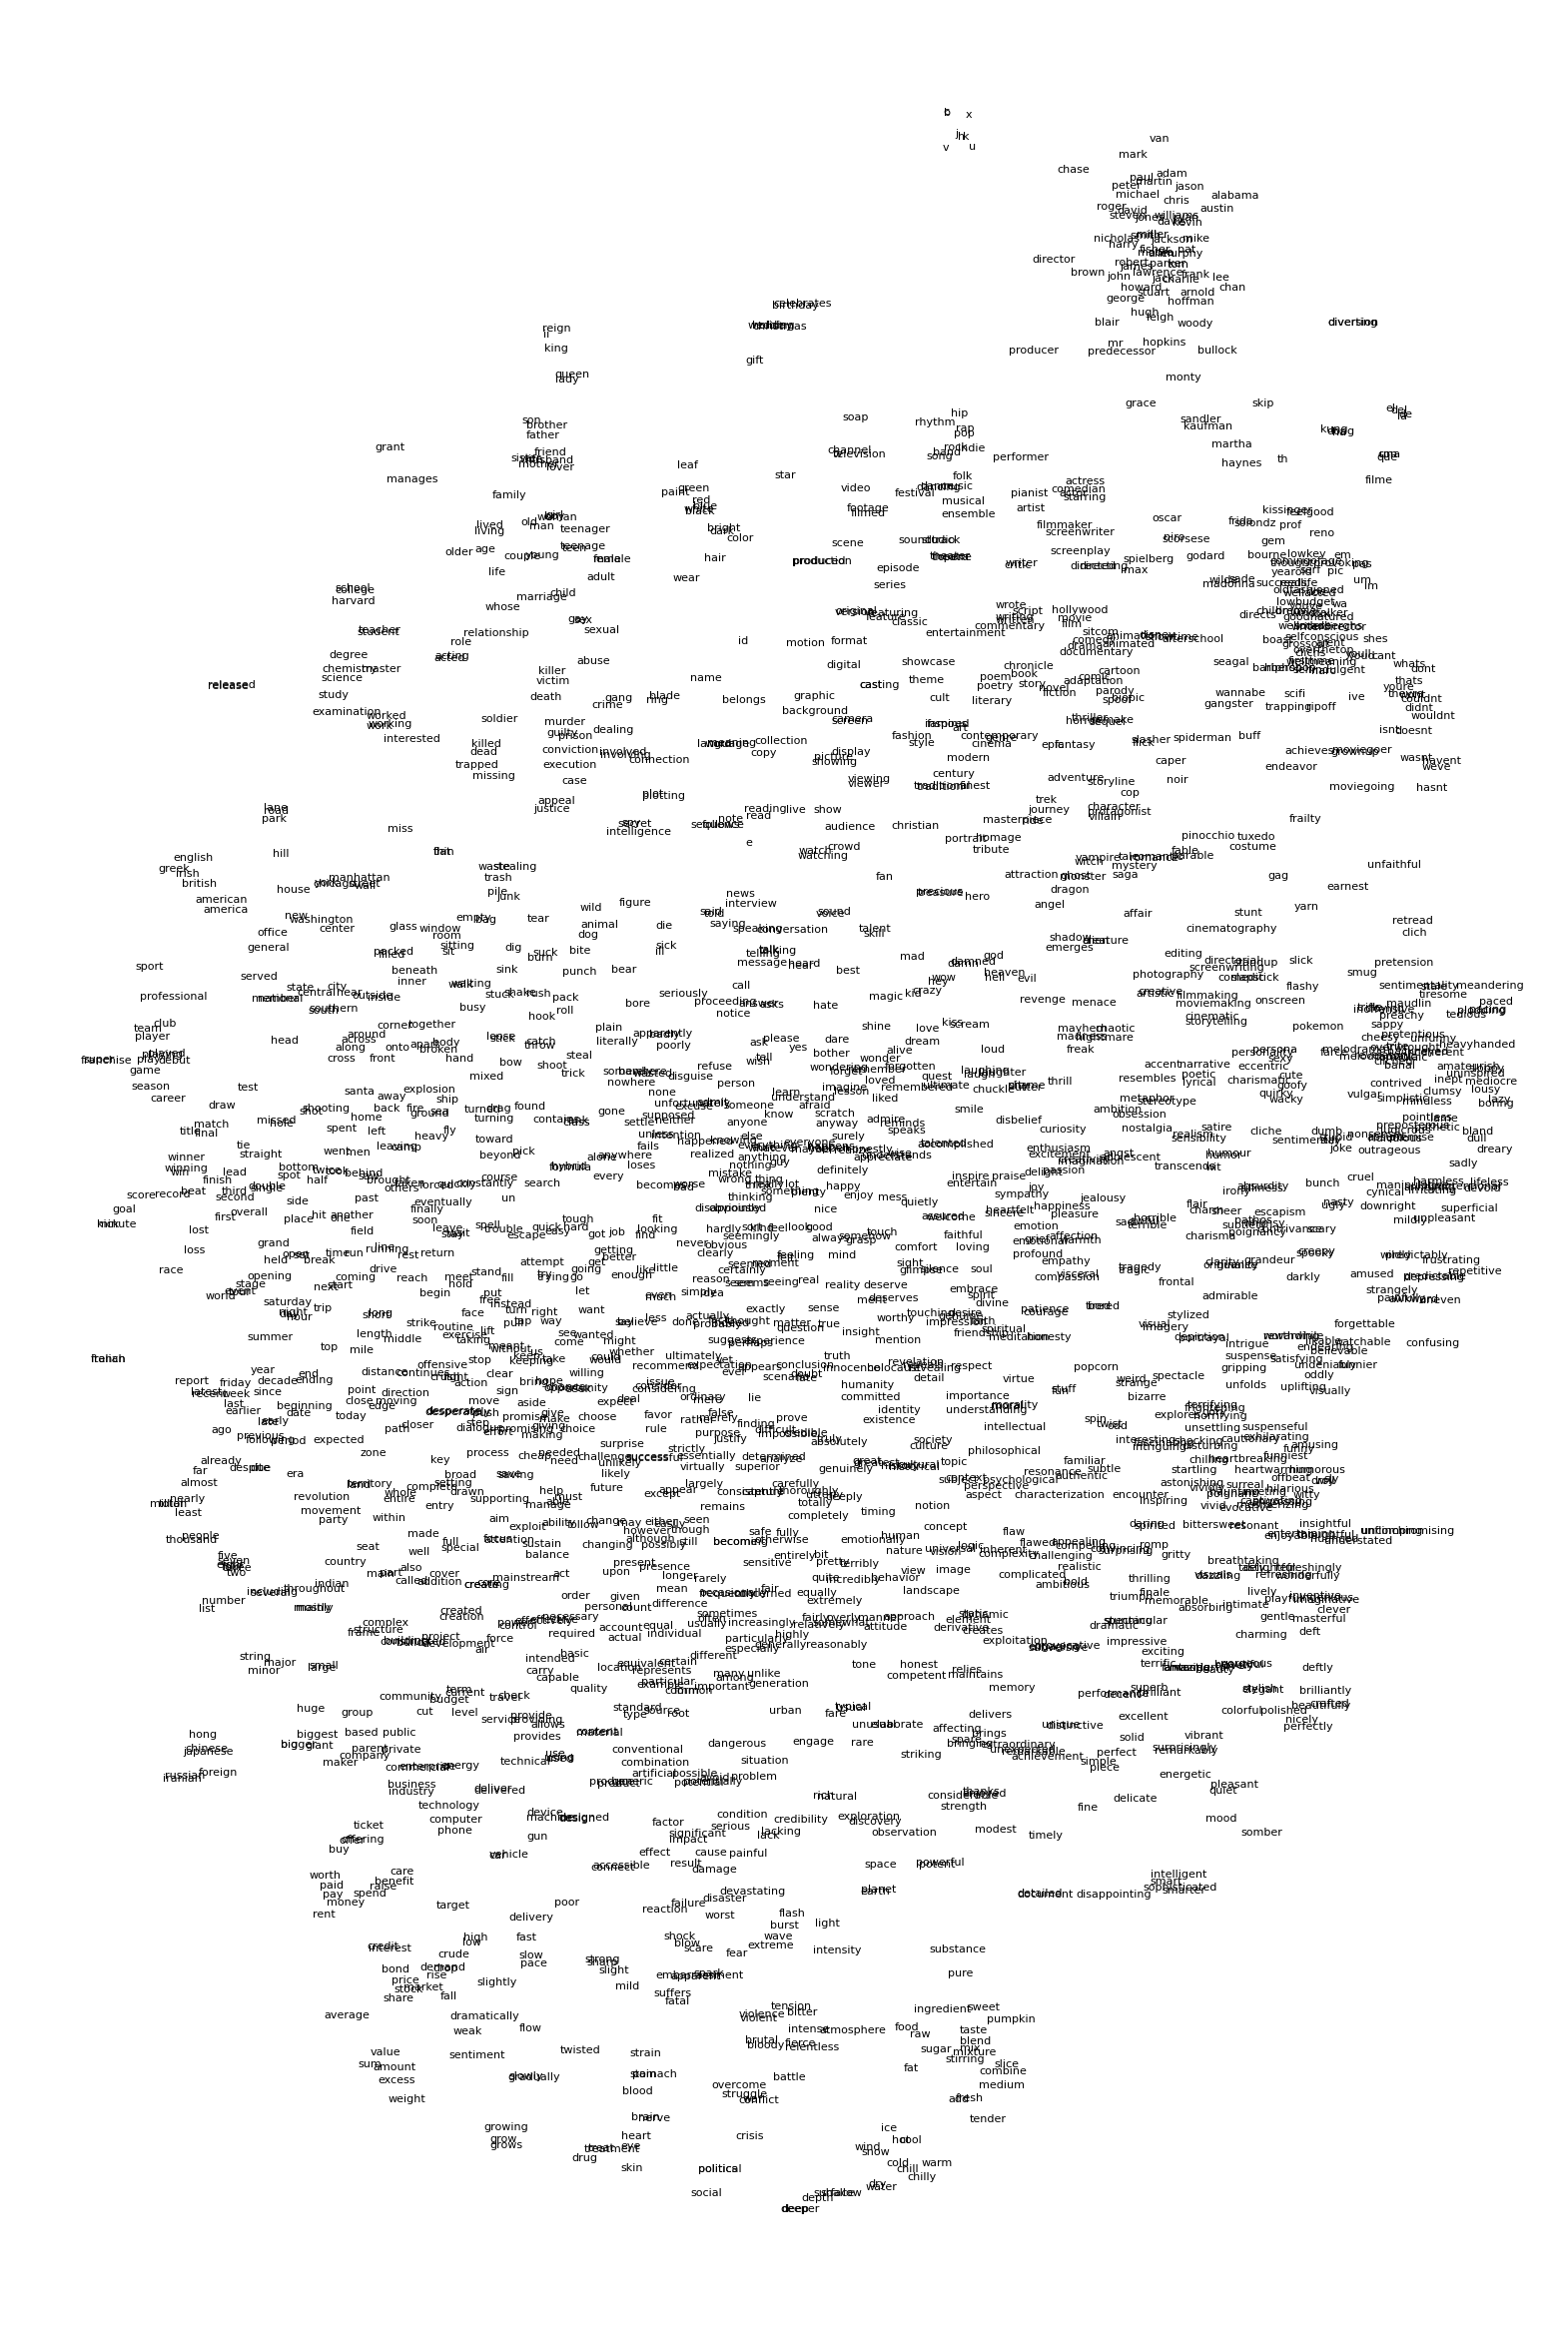

In [194]:
plot_embeddings_tsne(embedding_matrix)

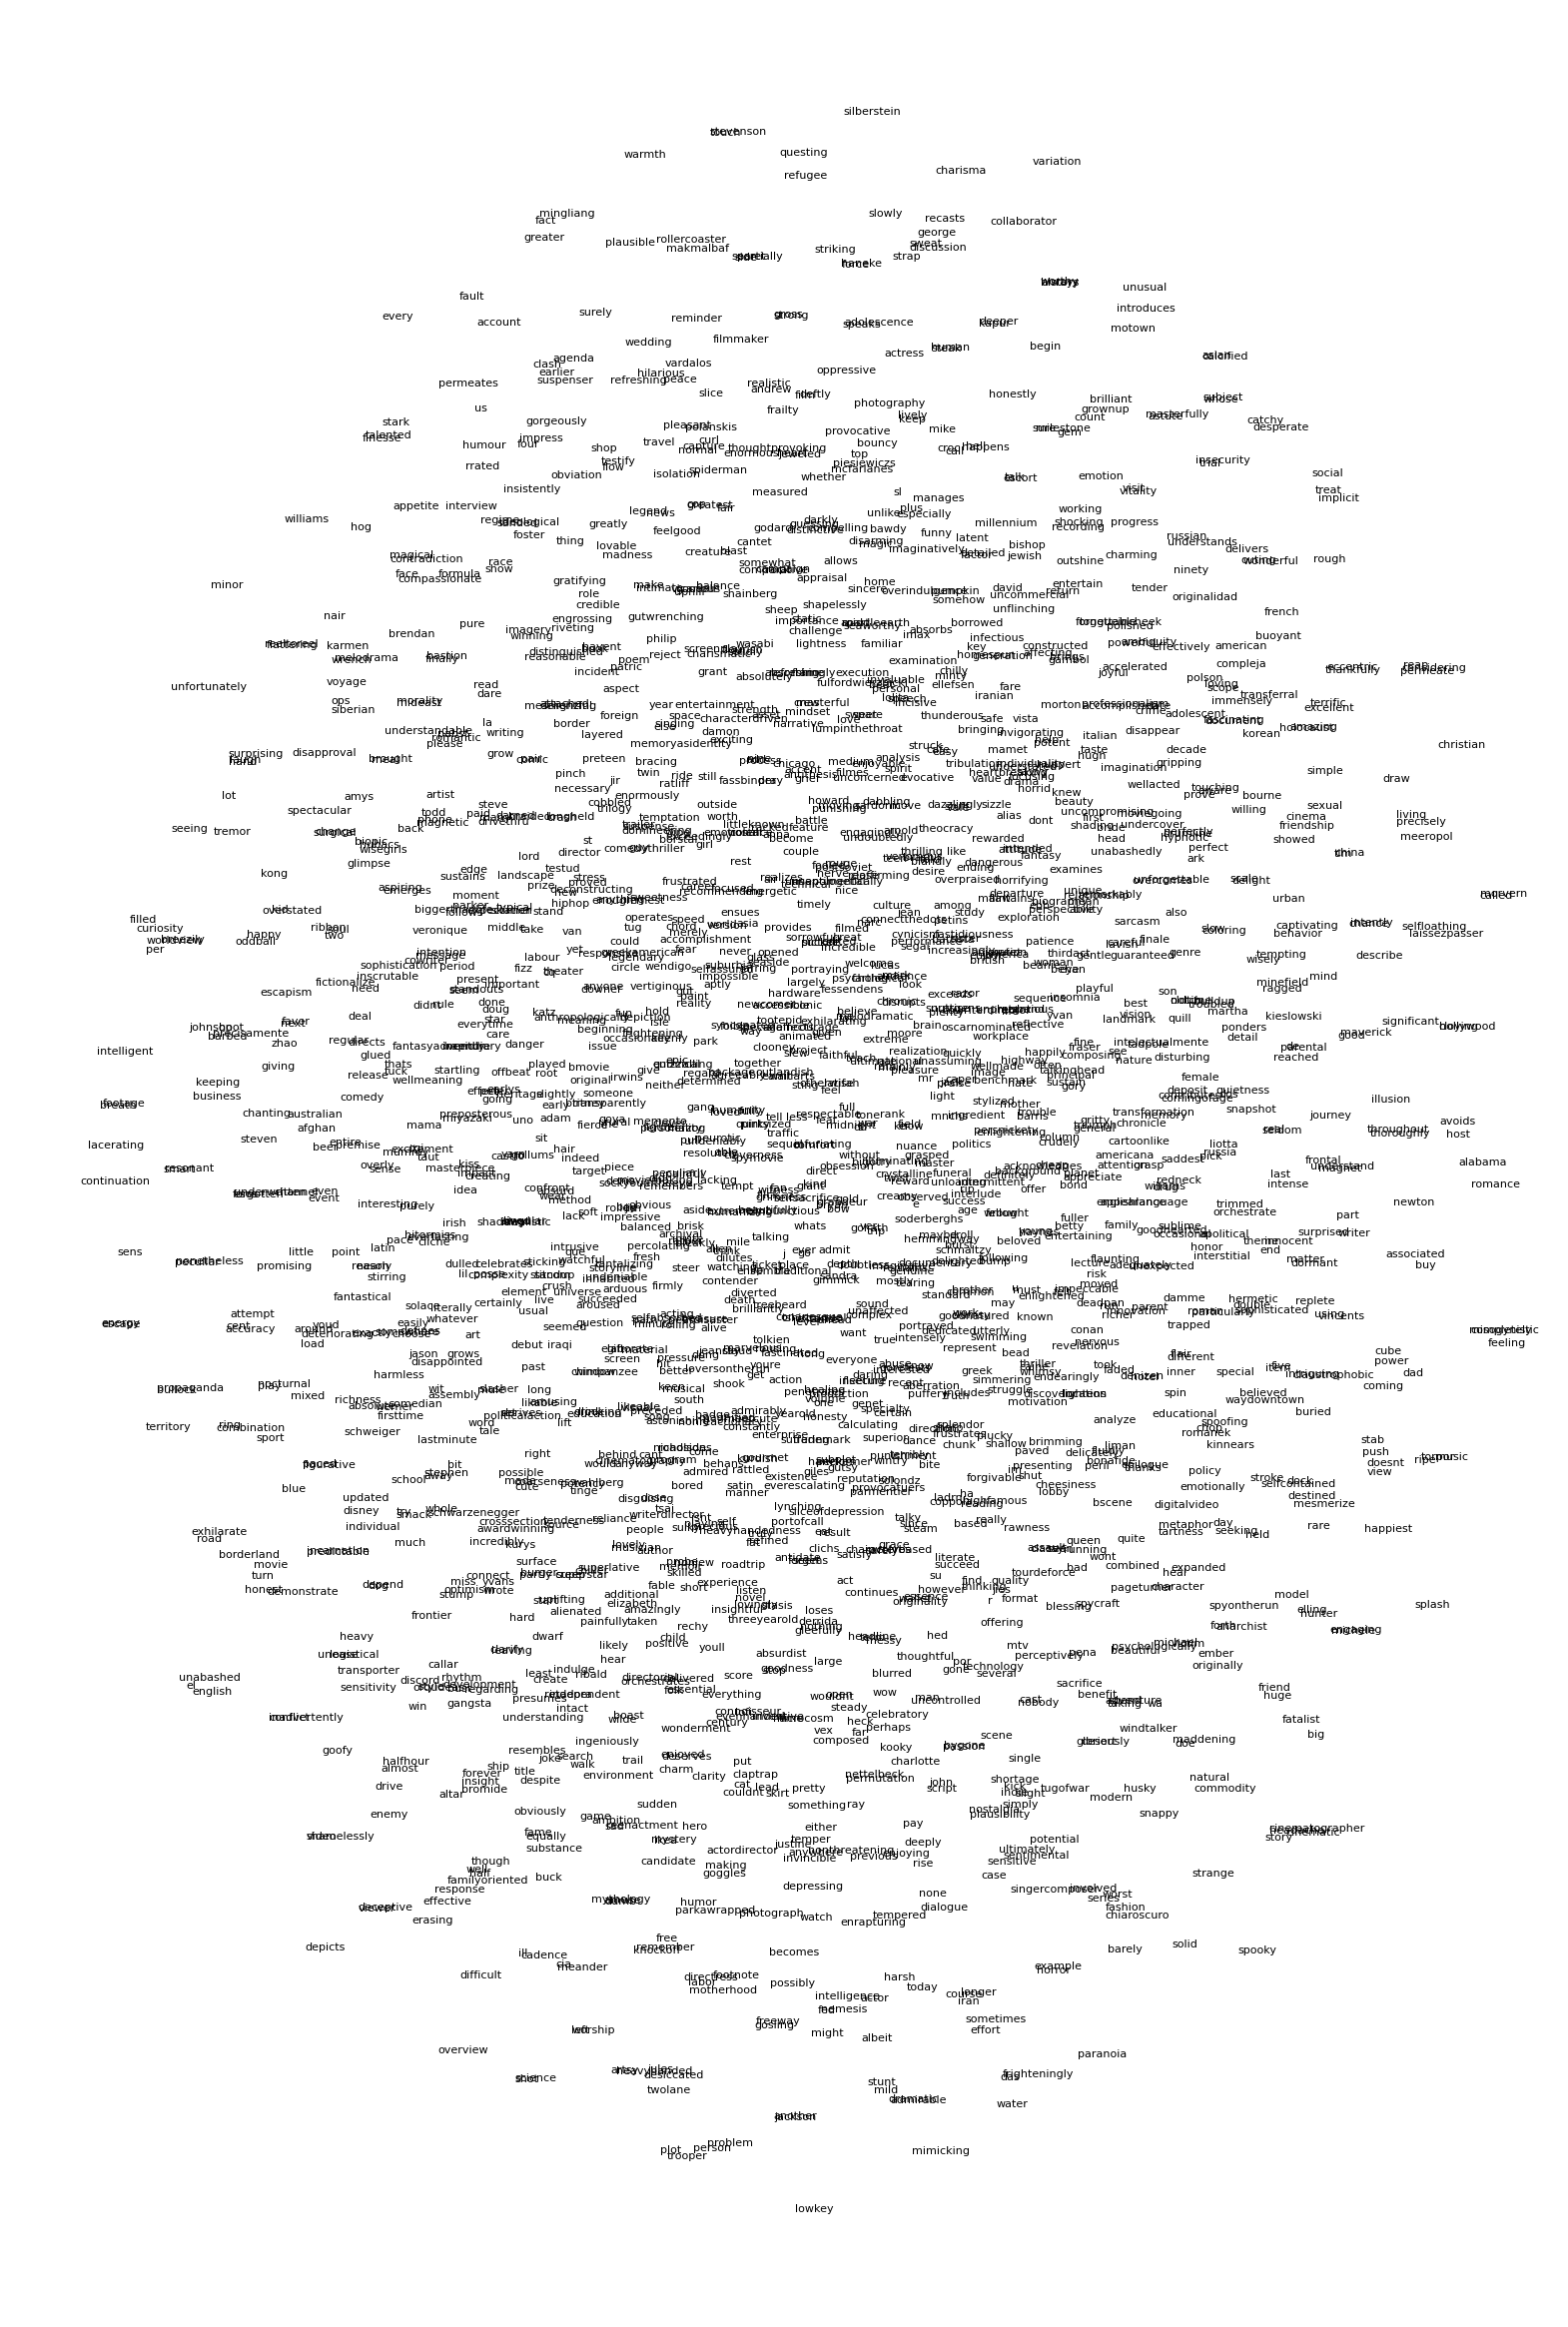

In [292]:
plot_embeddings_tsne(embeddings)

### Report requirements

1. Run a few experiments with different embedding dimensions, batch sizes, and number of epochs run. Try with and without the pre-trained GloVe embeddings. Across your experiments, did the pre-trained embeddings work better, or was it better to train your own embedding layer for this task? Did you notice any trends with certain parameters? What happens if you freeze the GloVe embeddings during training time?


In [ ]:
# Experiment 1


In [447]:
d = 200
h = 50
batch_size = 30
num_epochs = 10
learning_rate = 0.001

In [448]:
# Initialize the model
model_1 = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0
)

In [449]:
# Define the loss function and the optimizer
criterion_1 = nn.BCELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(3,0.01)

In [450]:
model_1, avg_train_losses_1, avg_val_losses_1 = train_model(model_1,train_loader,val_loader,criterion_1,optimizer_1,num_epochs,early_stopper)

Epoch 1, Training Loss: 0.6569
Validation Loss: 0.6170
Epoch 2, Training Loss: 0.4944
Validation Loss: 0.5886
Epoch 3, Training Loss: 0.3449
Validation Loss: 0.6177
Epoch 4, Training Loss: 0.2346
Validation Loss: 0.6903
Epoch 5, Training Loss: 0.1566
Validation Loss: 0.7895
Early Stop Triggered


In [451]:
evaluate_model(test_loader, model_1)

Accuracy: 0.7692
Precision: 0.7652
Recall: 0.7563
F1 Score: 0.7607


0.7607003891050583

In [452]:
embedding_dim = d
word_vectors = api.load(f"glove-wiki-gigaword-{embedding_dim}")

In [453]:
embedding_matrix = torch.zeros(len(token2index), embedding_dim)
for token, index in token2index.items():
  if token in word_vectors:
    embedding_matrix[index] = torch.tensor(word_vectors[token])

In [454]:

model_glove_1 = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=embedding_dim,
    padding_idx=0,
    pretrained_embeddings=embedding_matrix
)

In [455]:
# Define the loss function and the optimizer
criterion_glove_1 = nn.BCELoss()
optimizer_glove_1 = torch.optim.Adam(model_glove_1.parameters(), lr=0.001)
early_stopper = EarlyStopper(3,0.01)

In [456]:
model_glove_1, avg_train_losses_glove_1, avg_val_losses_glove_1 = train_model(model_glove_1,train_loader,val_loader,criterion_glove_1,optimizer_glove_1,num_epochs,early_stopper)

Epoch 1, Training Loss: 0.5913
Validation Loss: 0.5160
Epoch 2, Training Loss: 0.3773
Validation Loss: 0.5210
Epoch 3, Training Loss: 0.2395
Validation Loss: 0.5876
Epoch 4, Training Loss: 0.1463
Validation Loss: 0.6789
Epoch 5, Training Loss: 0.0880
Validation Loss: 0.7812
Early Stop Triggered


In [457]:
evaluate_model(test_loader, model_glove_1)

Accuracy: 0.7795
Precision: 0.7592
Recall: 0.7988
F1 Score: 0.7785


0.7785108388312912

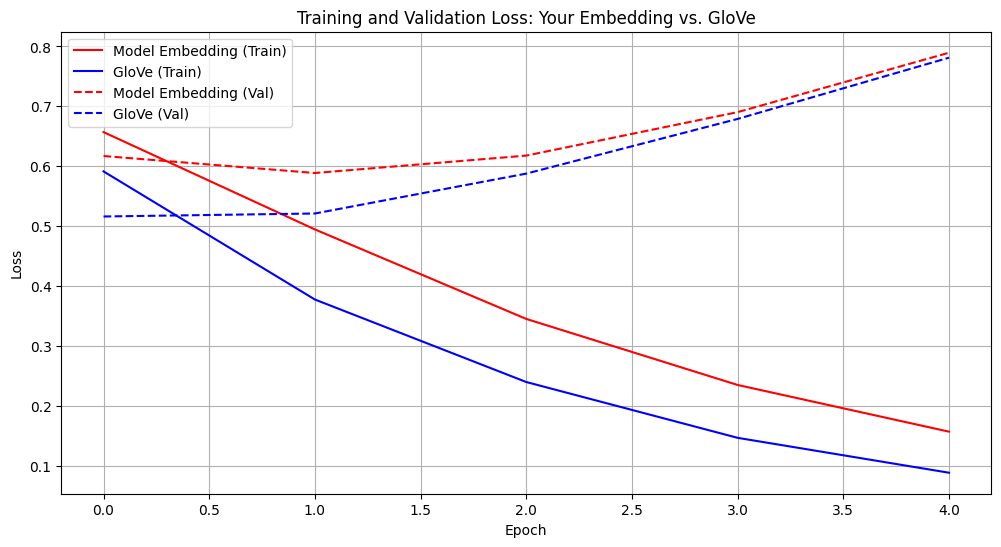

In [458]:
plot_comparison_graph(avg_train_losses_1, avg_train_losses_glove_1, avg_val_losses_1, avg_val_losses_glove_1)

In [459]:
embeddings_1 = model_1.embedding.weight.data

In [463]:
words_to_compare = ["good", "bad"]

# Own embeddings
for word in words_to_compare:
    print(f"Nearest neighbors for '{word}' in own embeddings:")
    print(k_nearest_neighbors(embeddings_1, token2index, index2token, word, 10))

# GloVe embeddings
for word in words_to_compare:
    print(f"Nearest neighbors for '{word}' in GloVe embeddings:")
    print(k_nearest_neighbors(embedding_matrix, token2index, index2token, word, 10))

Nearest neighbors for 'good' in own embeddings:
['window', 'greed', 'couture', 'veering', 'trilogy', 'jean', 'expands', 'preferably', 'kinnear', 'ghandi']
Nearest neighbors for 'bad' in own embeddings:
['dreamscape', 'goodness', 'execrable', 'symmetry', 'grocery', 'amish', 'booking', 'accent', 'freaking', 'alabama']
Nearest neighbors for 'good' in GloVe embeddings:
['always', 'you', 'better', 'way', 'excellent', 'well', 'really', 'get', 'we', 'going']
Nearest neighbors for 'bad' in GloVe embeddings:
['really', 'too', 'nothing', 'good', 'so', 'kind', 'going', 'wrong', 'think', 'awful']


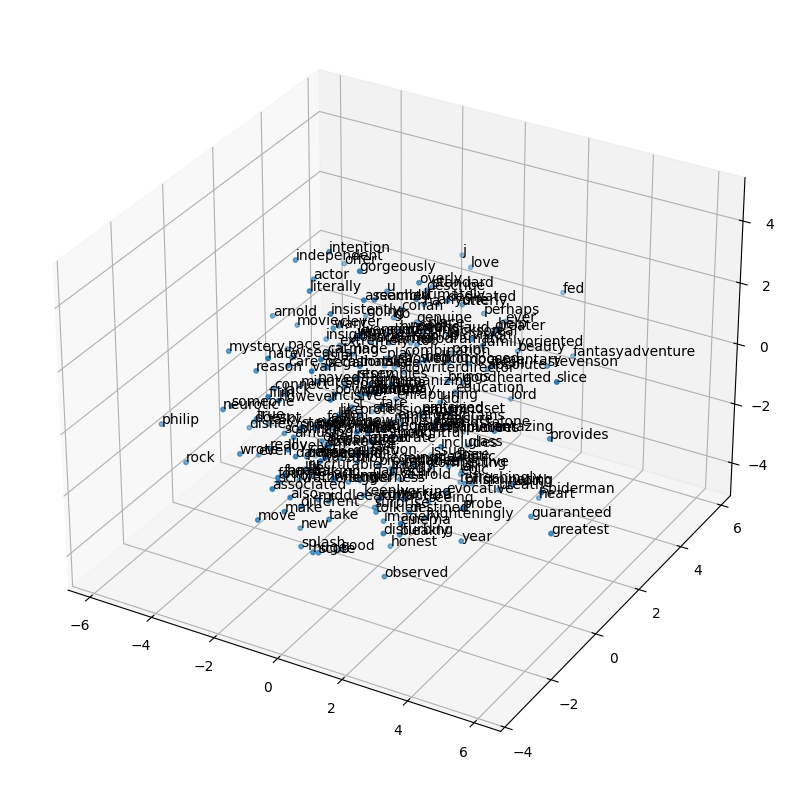

In [464]:
plot_embeddings_3d(embeddings_1)

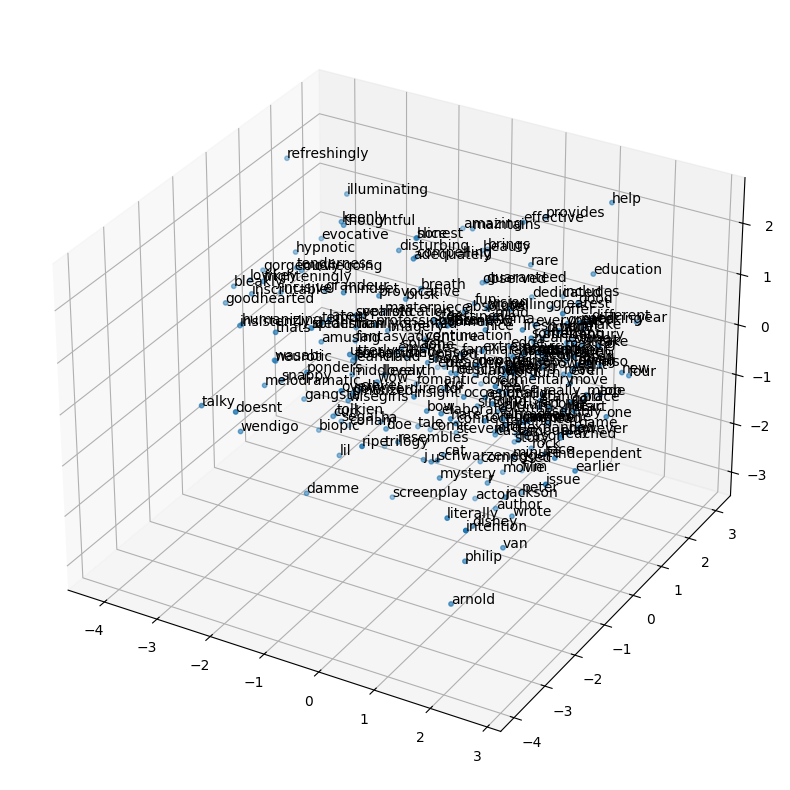

In [465]:
plot_embeddings_3d(embedding_matrix)

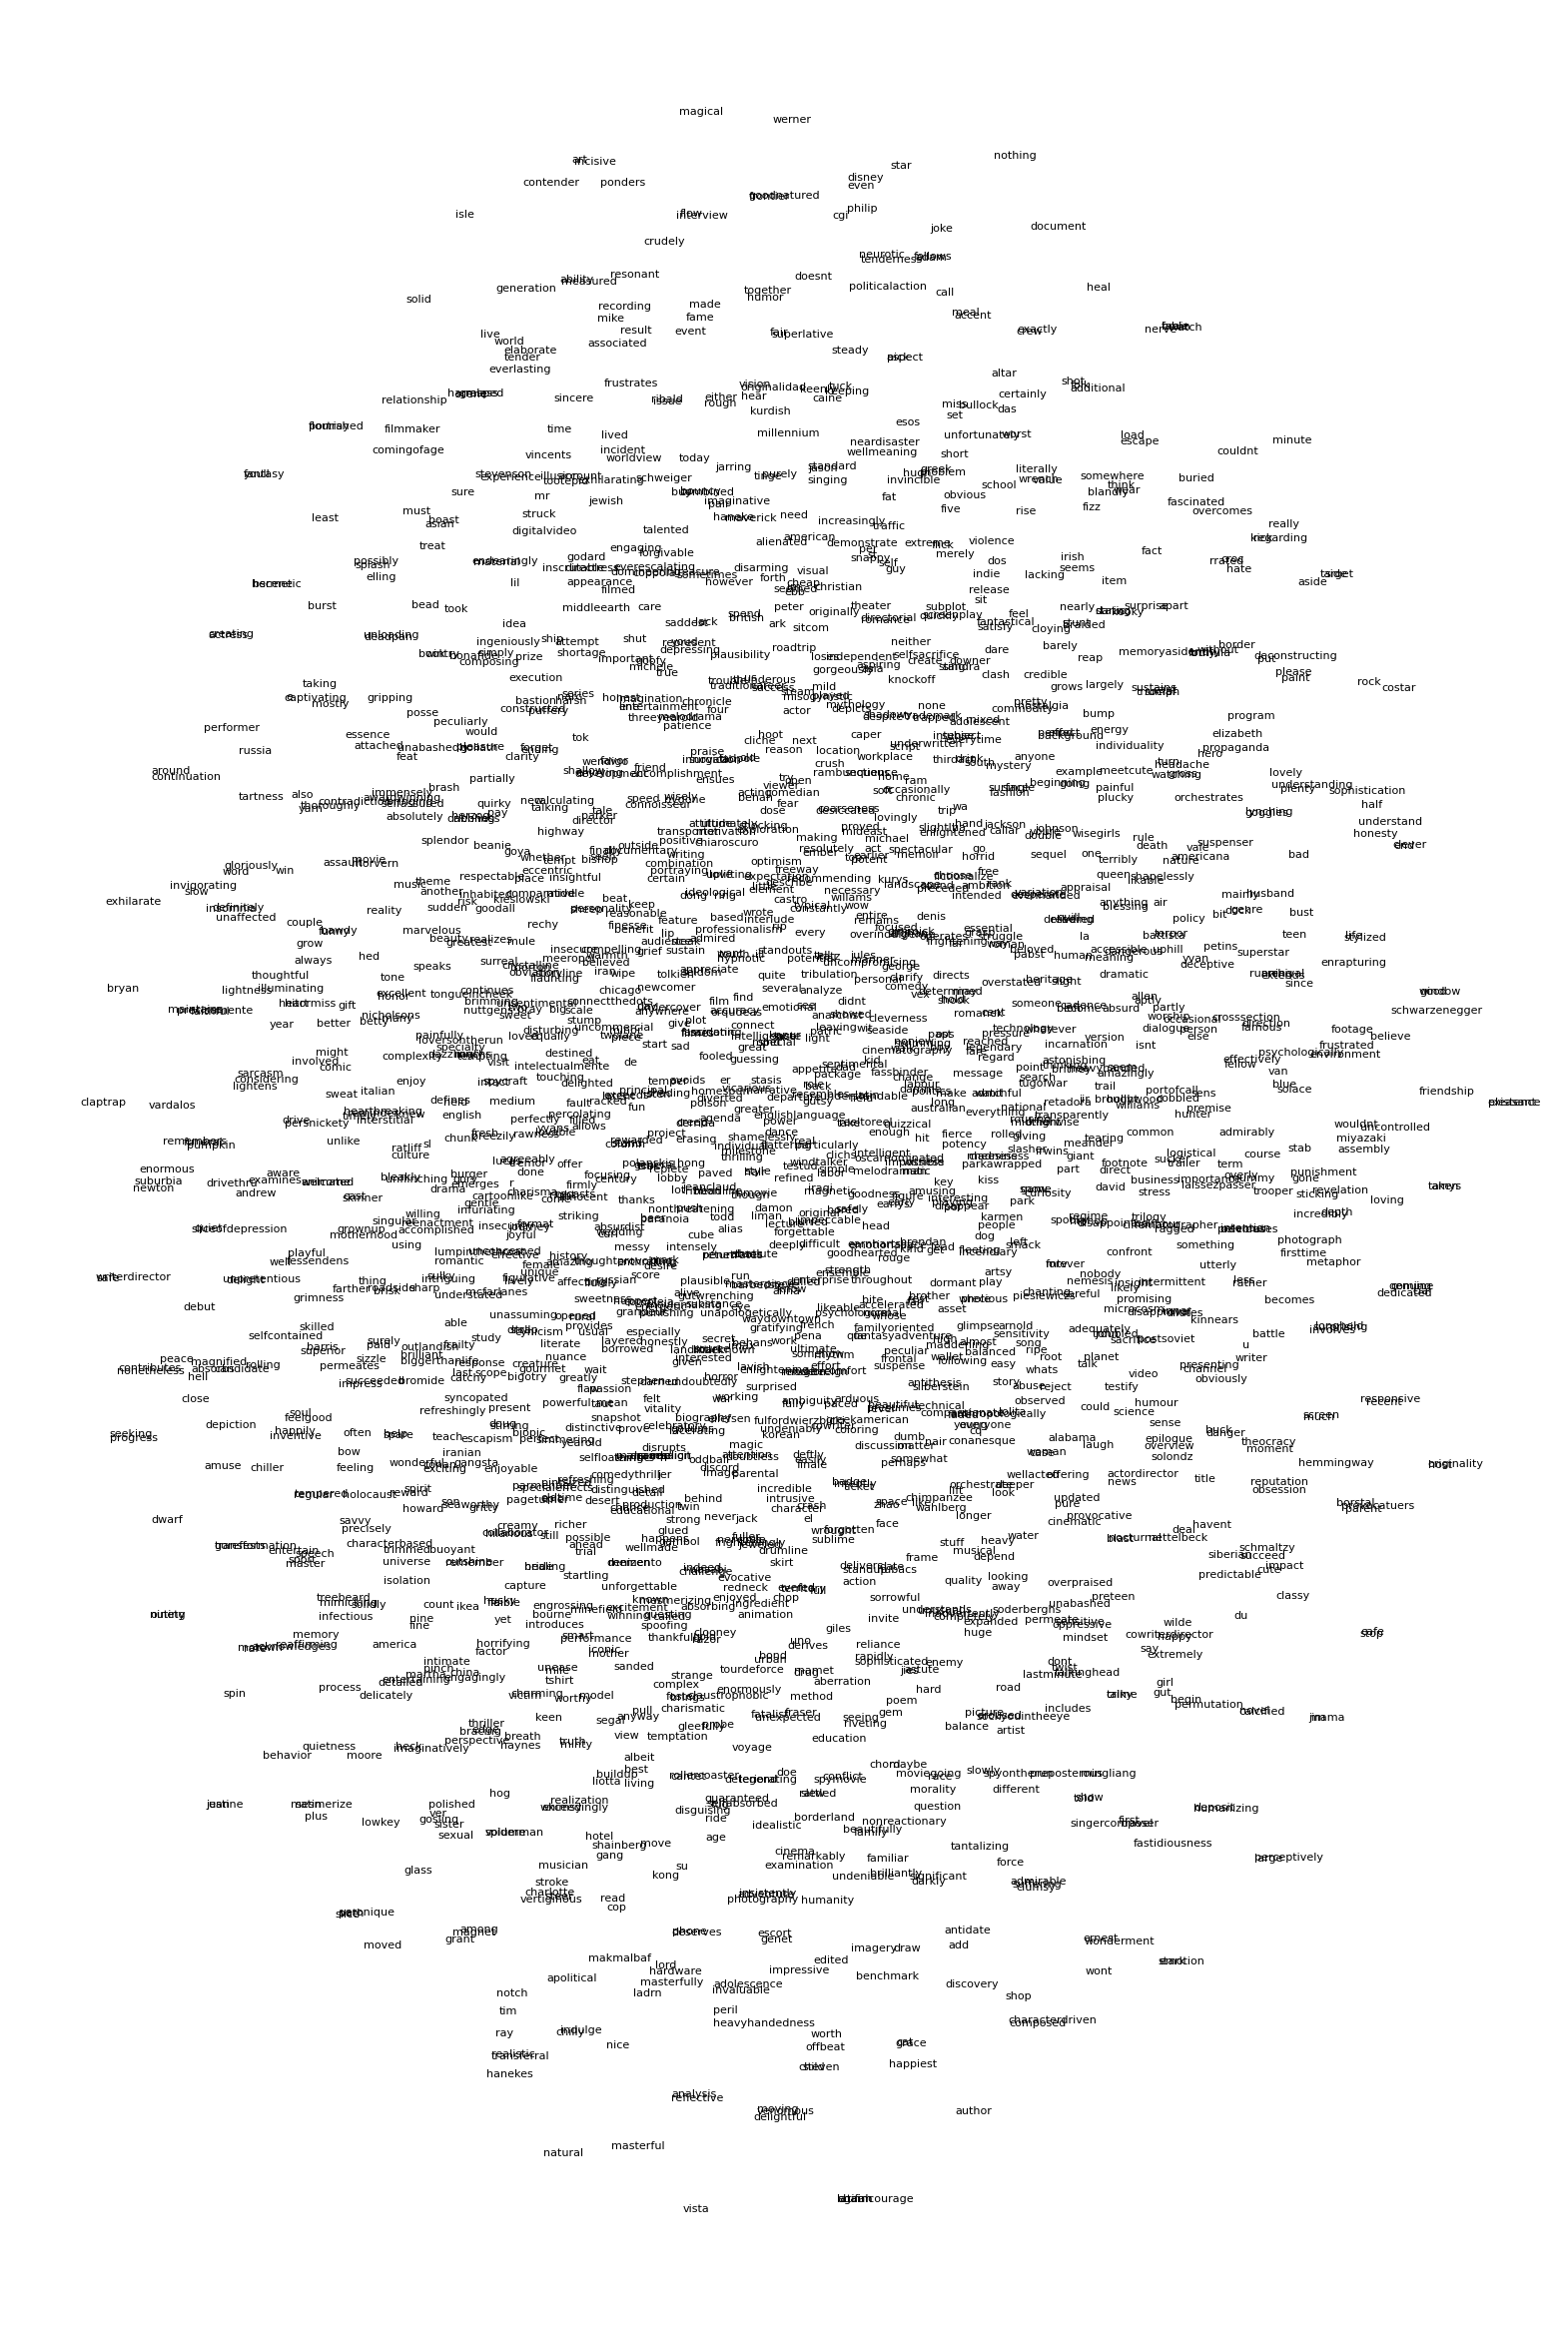

In [466]:
plot_embeddings_tsne(embeddings_1)

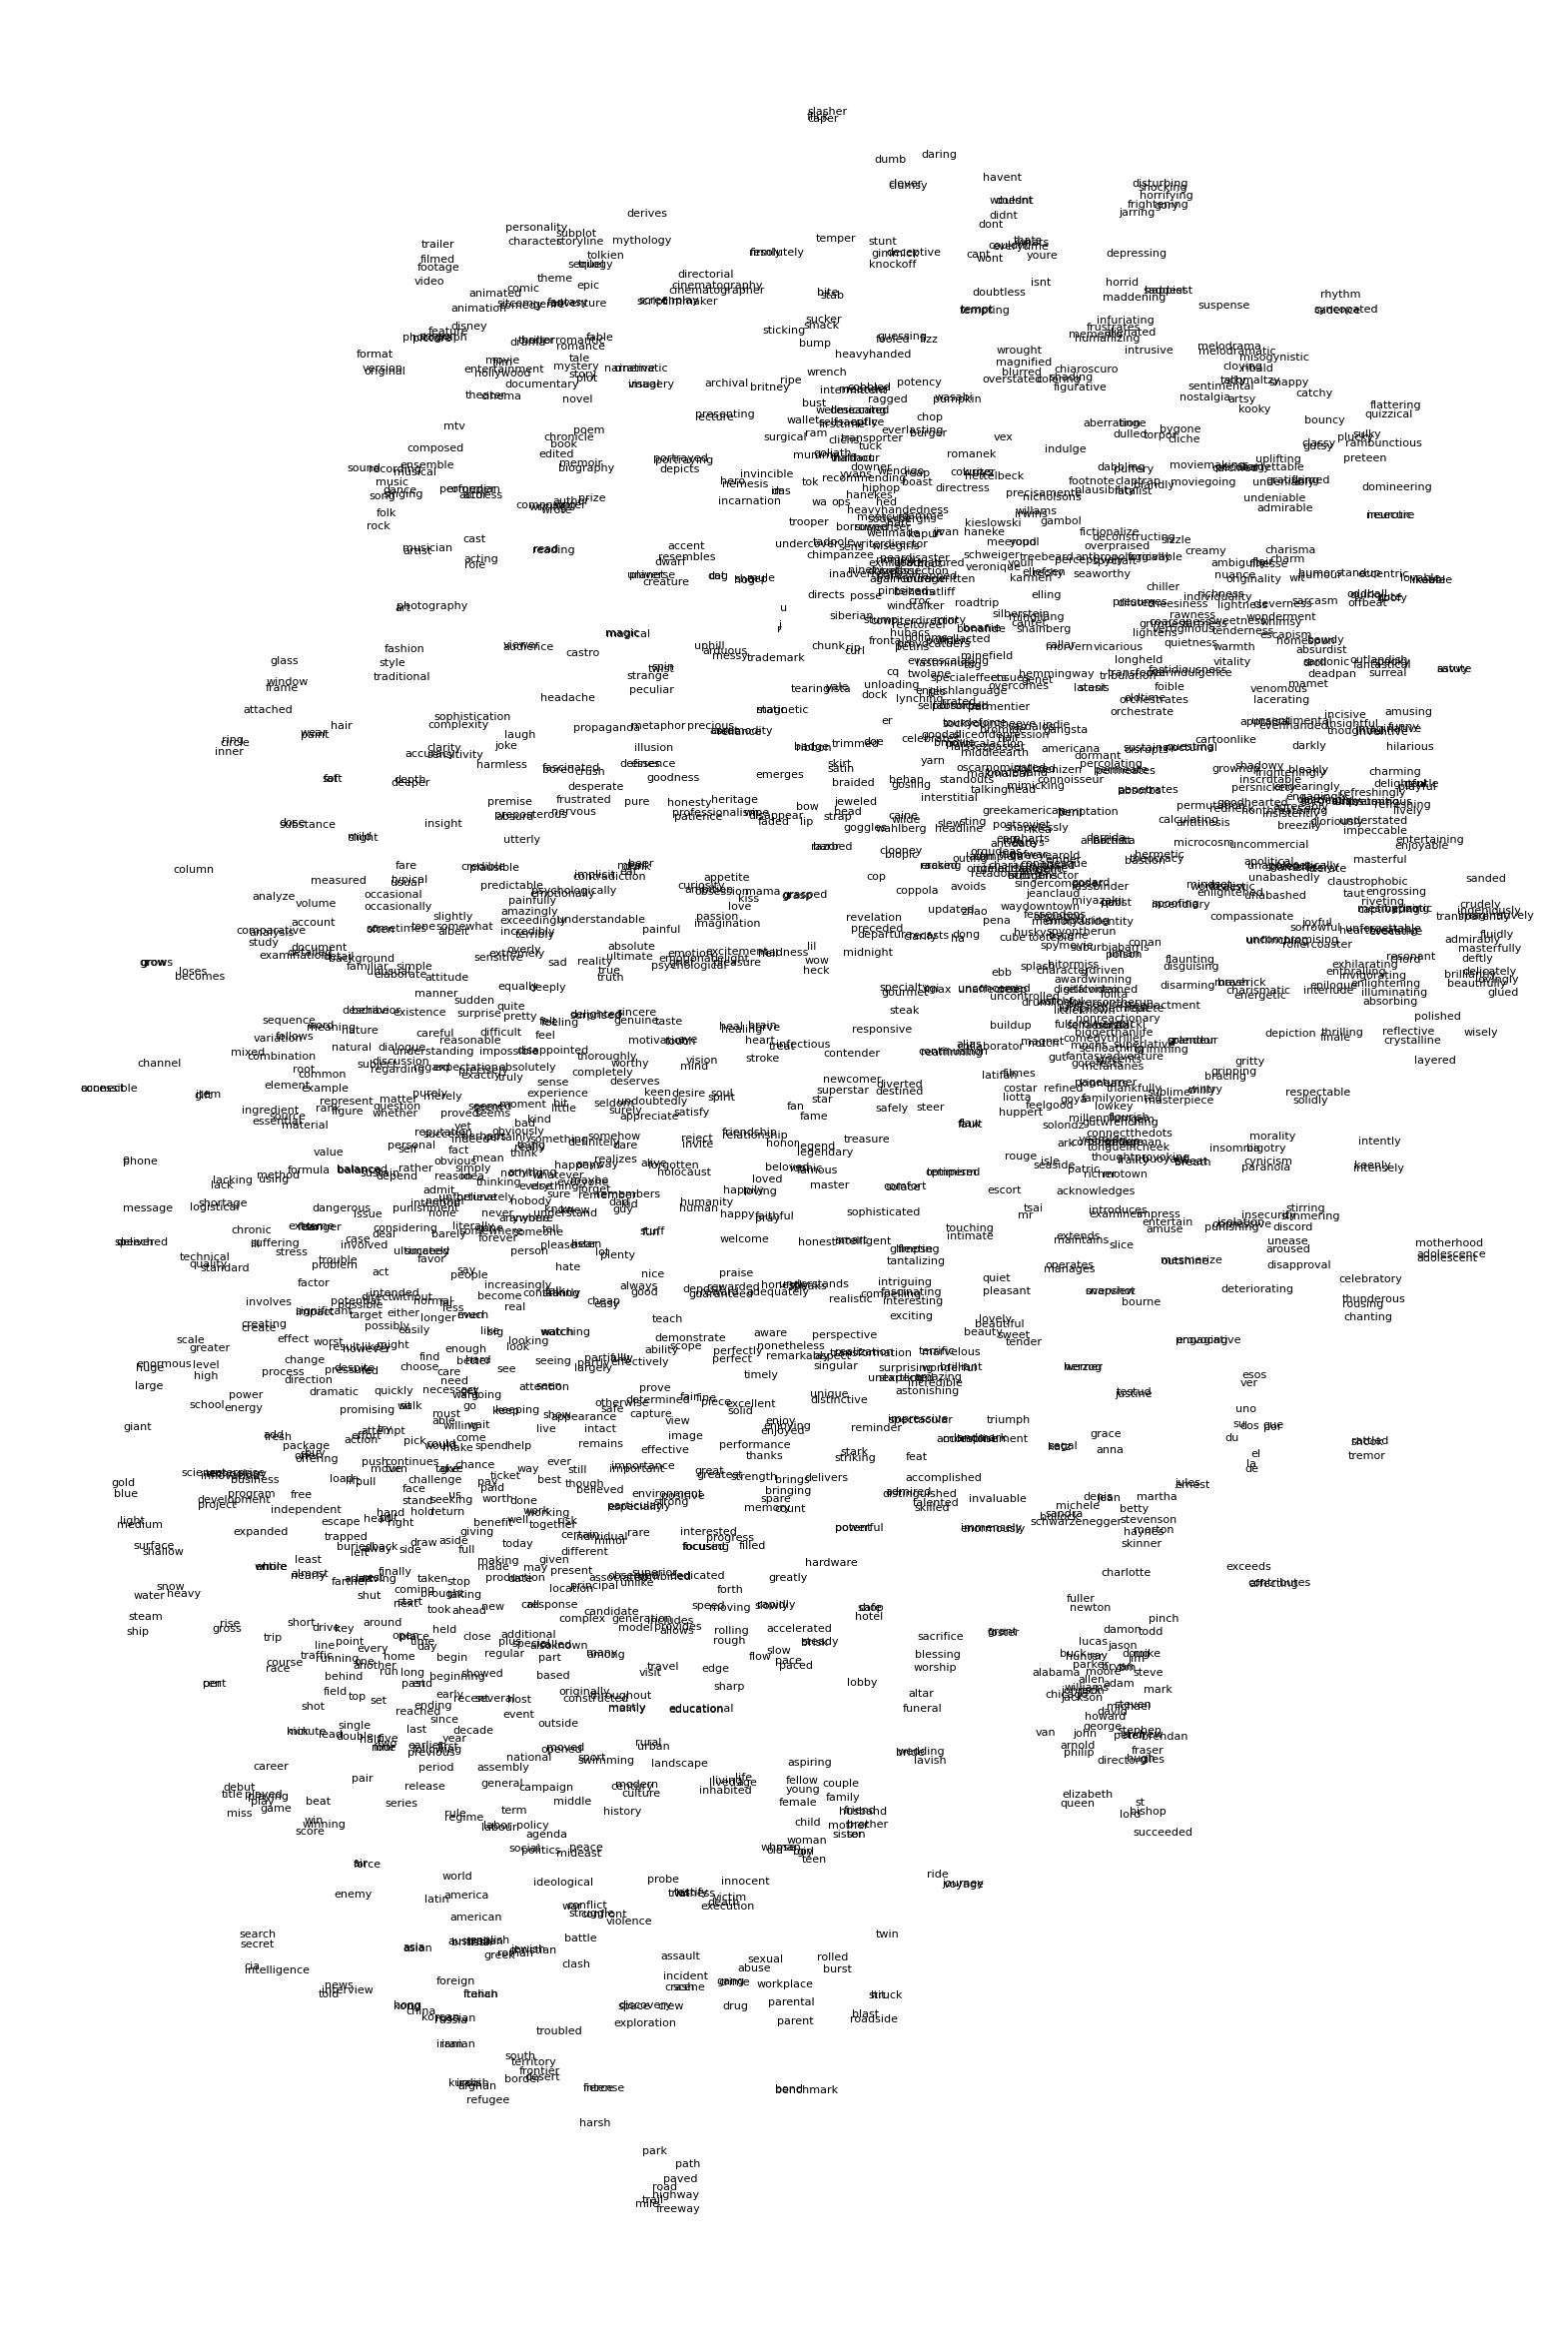

In [467]:
plot_embeddings_tsne(embedding_matrix)

In [ ]:
### Trying below with Freeze embeddings TRUE

In [469]:
# Testing with freeze embeddings
model_glove_1_freeze = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=embedding_dim,
    padding_idx=0,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=True
)

In [470]:
# Define the loss function and the optimizer
criterion_glove_1_f = nn.BCELoss()
optimizer_glove_1_f = torch.optim.Adam(model_glove_1_freeze.parameters(), lr=0.001)
early_stopper = EarlyStopper(3,0.01)

In [471]:
model_glove_1_freeze, avg_train_losses_glove_1_f, avg_val_losses_glove_1_f = train_model(model_glove_1_freeze,train_loader,val_loader,criterion_glove_1_f,optimizer_glove_1_f,num_epochs,early_stopper)

Epoch 1, Training Loss: 0.2433
Validation Loss: 0.6532
Epoch 2, Training Loss: 0.0522
Validation Loss: 0.8465
Epoch 3, Training Loss: 0.0410
Validation Loss: 0.9669
Epoch 4, Training Loss: 0.0377
Validation Loss: 1.0469
Early Stop Triggered


In [472]:
evaluate_model(test_loader, model_glove_1_freeze)

Accuracy: 0.7692
Precision: 0.7450
Recall: 0.7969
F1 Score: 0.7701


0.7700934579439253

In [423]:
import pandas as pd

In [ ]:
def run_experiments(embedding_dims, batch_sizes, token2index, embedding_matrix=None):
    results = []

    for d in embedding_dims:
        embedding_dim = d
        word_vectors = api.load(f"glove-wiki-gigaword-{embedding_dim}")

        for batch_size in batch_sizes:
                print("for embedding dimension: ", d, "and batch size: ", batch_size)
            # for num_epochs in num_epochs_list: removed the num_epochs parameter
                num_epochs = 10
                h = 50
                learning_rate = 0.001

                train_loader = DataLoader(train_data, batch_size=batch_size)
                val_loader = DataLoader(val_data, batch_size=batch_size)
                test_loader = DataLoader(test_data, batch_size=len(test_data))

                # Model with own embeddings
                model_own = Net(
                    input_size=d,
                    output_size=1,
                    hidden_size=h,
                    num_embeddings=len(token2index),
                    embedding_dim=d,
                    padding_idx=0
                )

                criterion = torch.nn.BCELoss()
                optimizer = torch.optim.Adam(model_own.parameters(), lr=learning_rate)
                early_stopper = EarlyStopper(3, 0.01)

                model_own, _, _ = train_model(model_own, train_loader, val_loader, criterion, optimizer, num_epochs, early_stopper)
                f1_own = evaluate_model(val_loader, model_own)

                results.append([d, batch_size, num_epochs, 'Own Embeddings', f1_own])

                embedding_matrix = torch.zeros(len(token2index), embedding_dim)
                for token, index in token2index.items():
                    if token in word_vectors:
                        embedding_matrix[index] = torch.tensor(word_vectors[token])

                # Model with GloVe embeddings
                if embedding_matrix is not None:
                    model_glove = Net(
                        input_size=d,
                        output_size=1,
                        hidden_size=h,
                        num_embeddings=len(token2index),
                        embedding_dim=d,
                        padding_idx=0,
                        pretrained_embeddings=embedding_matrix
                    )

                    optimizer_glove = torch.optim.Adam(model_glove.parameters(), lr=learning_rate)
                    model_glove, _, _ = train_model(model_glove, train_loader, val_loader, criterion, optimizer_glove, num_epochs, early_stopper)
                    f1_glove = evaluate_model(val_loader, model_glove)

                    results.append([d, batch_size, num_epochs, 'GloVe Embeddings', f1_glove])

    df_results = pd.DataFrame(results, columns=['Embedding Dim', 'Batch Size', 'Num Epochs', 'Embedding Type', 'F1 Score'])
    return df_results


In [445]:
df_results = run_experiments([50, 100, 200], [10, 20, 30], token2index, embedding_matrix)

for  50 and 10
Epoch 1, Training Loss: 0.6718
Validation Loss: 0.6375
Epoch 2, Training Loss: 0.5566
Validation Loss: 0.5766
Epoch 3, Training Loss: 0.4261
Validation Loss: 0.5720
Epoch 4, Training Loss: 0.3250
Validation Loss: 0.5965
Epoch 5, Training Loss: 0.2460
Validation Loss: 0.6411
Epoch 6, Training Loss: 0.1844
Validation Loss: 0.7023
Early Stop Triggered
Accuracy: 0.7000
Precision: 0.2500
Recall: 1.0000
F1 Score: 0.4000
Epoch 1, Training Loss: 0.6233
Validation Loss: 0.5606
Epoch 2, Training Loss: 0.4496
Validation Loss: 0.5154
Epoch 3, Training Loss: 0.3212
Validation Loss: 0.5364
Epoch 4, Training Loss: 0.2244
Validation Loss: 0.5968
Epoch 5, Training Loss: 0.1529
Validation Loss: 0.6791
Early Stop Triggered
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
for  50 and 20
Epoch 1, Training Loss: 0.6830
Validation Loss: 0.6643
Epoch 2, Training Loss: 0.6031
Validation Loss: 0.6214
Epoch 3, Training Loss: 0.4904
Validation Loss: 0.6092
Epoch 4, Training Loss: 

In [446]:
print(df_results)

    Embedding Dim  Batch Size  Num Epochs    Embedding Type  F1 Score
0              50          10          10    Own Embeddings  0.400000
1              50          10          10  GloVe Embeddings  1.000000
2              50          20          10    Own Embeddings  0.615385
3              50          20          10  GloVe Embeddings  0.666667
4              50          30          10    Own Embeddings  0.782609
5              50          30          10  GloVe Embeddings  0.785714
6             100          10          10    Own Embeddings  0.500000
7             100          10          10  GloVe Embeddings  1.000000
8             100          20          10    Own Embeddings  0.666667
9             100          20          10  GloVe Embeddings  0.666667
10            100          30          10    Own Embeddings  0.700000
11            100          30          10  GloVe Embeddings  0.695652
12            200          10          10    Own Embeddings  0.666667
13            200   

In [443]:
words_to_compare = ["good", "bad"]

# Own embeddings
for word in words_to_compare:
    print(f"Nearest neighbors for '{word}' in own embeddings:")
    print(k_nearest_neighbors(embeddings, token2index, index2token, word, 10))

# GloVe embeddings
for word in words_to_compare:
    print(f"Nearest neighbors for '{word}' in GloVe embeddings:")
    print(k_nearest_neighbors(embedding_matrix, token2index, index2token, word, 10))

Nearest neighbors for 'good' in own embeddings:
['wannabehip', 'lionize', 'reawaken', 'kong', 'munch', 'filmgoers', 'maverick', 'malapropism', 'purposeless', 'grateful']
Nearest neighbors for 'bad' in own embeddings:
['diop', 'quickcuts', 'sprout', 'tracy', 'rut', 'cuba', 'tickled', 'fusion', 'pardia', 'cynicism']
Nearest neighbors for 'good' in GloVe embeddings:
['way', 'you', 'ever', 'make', 'my', 'something', 'once', 'got', 'lot', 'work']
Nearest neighbors for 'bad' in GloVe embeddings:
['too', 'nothing', 'why', 'everything', 'indeed', 'wrong', 'feel', 'how', 'reason', 'so']
